Time cost (Bias computation): 1.0s

Baseline Model Evaluation (Yelp)
MAE = 1.1437658136030375


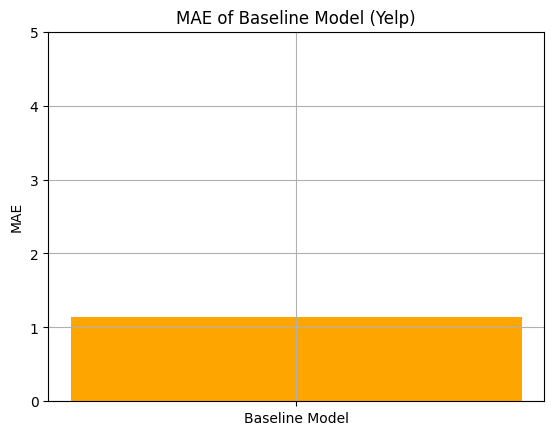

In [ ]:
# Baseline Model (mu + bu + bi) - Yelp Dataset

import pandas as pd
import numpy as np
import time
from scipy import sparse
import matplotlib.pyplot as plt

# Load and split Yelp data
def load_and_split_yelp_data():
    ratings_df = pd.read_csv('ratings.csv')
    ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
    ratings_df = ratings_df.sort_values(['User ID', 'Date'])

    unique_users = sorted(ratings_df['User ID'].unique())
    unique_businesses = sorted(ratings_df['Business ID'].unique())

    user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
    business_to_idx = {business_id: idx for idx, business_id in enumerate(unique_businesses)}

    train_data = []
    test_data = []

    for user_id in unique_users:
        user_ratings = ratings_df[ratings_df['User ID'] == user_id].copy()
        n_ratings = len(user_ratings)

        if n_ratings == 1:
            train_data.extend(user_ratings.values.tolist())
        else:
            n_train = int(np.floor(n_ratings * 0.8))
            train_ratings = user_ratings.iloc[:n_train]
            test_ratings = user_ratings.iloc[n_train:]
            train_data.extend(train_ratings.values.tolist())
            test_data.extend(test_ratings.values.tolist())

    train_df = pd.DataFrame(train_data, columns=['User ID', 'Business ID', 'Rating', 'Date'])
    test_df = pd.DataFrame(test_data, columns=['User ID', 'Business ID', 'Rating', 'Date'])

    return train_df, test_df, user_to_idx, business_to_idx, len(unique_users), len(unique_businesses)

# Create sparse matrices
def create_sparse_matrices(train_df, test_df, user_to_idx, business_to_idx, num_users, num_businesses):
    train_user_indices = [user_to_idx[uid] for uid in train_df['User ID']]
    train_business_indices = [business_to_idx[bid] for bid in train_df['Business ID']]
    train_ratings = train_df['Rating'].values

    sp_training = sparse.csr_matrix(
        (train_ratings, (train_user_indices, train_business_indices)),
        shape=(num_users, num_businesses),
        dtype=np.float64
    )

    test_user_indices = [user_to_idx[uid] for uid in test_df['User ID']]
    test_business_indices = [business_to_idx[bid] for bid in test_df['Business ID']]
    test_ratings = test_df['Rating'].values

    sp_test = sparse.csr_matrix(
        (test_ratings, (test_user_indices, test_business_indices)),
        shape=(num_users, num_businesses),
        dtype=np.float64
    )

    return sp_training, sp_test, num_users, num_businesses

# Predict using baseline formula
def predict(user, item):
    return mu + bu[user] + bi[item]

# Compute MAE
def computeMAE():
    MAE = 0.0
    rows, cols = sp_test.nonzero()
    for j in range(len(rows)):
        actual = sp_test[rows[j], cols[j]]
        predicted = predict(rows[j], cols[j])
        MAE += abs(actual - predicted)
    MAE /= len(rows)
    return MAE

# Run test
def test():
    print("\nBaseline Model Evaluation (Yelp)")
    MAE = computeMAE()
    print("MAE =", MAE)

    # plot MAE result
    plt.bar(['Baseline Model'], [MAE], color='orange')
    plt.title('MAE of Baseline Model (Yelp)')
    plt.ylabel('MAE')
    plt.ylim(0, 5)
    plt.grid(True)
    plt.show()

# Main
if __name__ == '__main__':
    train_df, test_df, user_to_idx, business_to_idx, num_users, num_items = load_and_split_yelp_data()
    sp_training, sp_test, num_users, num_items = create_sparse_matrices(train_df, test_df, user_to_idx, business_to_idx, num_users, num_items)

    start = time.time()

    mu = sp_training.data.mean()
    bu = np.zeros(num_users)
    bi = np.zeros(num_items)

    # Compute user bias
    for u in range(num_users):
        user_ratings = sp_training.getrow(u).toarray().flatten()
        rated = user_ratings > 0
        if np.any(rated):
            bu[u] = np.mean(user_ratings[rated] - mu)

    # Compute item bias
    for i in range(num_items):
        item_ratings = sp_training.getcol(i).toarray().flatten()
        rated = item_ratings > 0
        if np.any(rated):
            bi[i] = np.mean(item_ratings[rated] - mu)

    end = time.time()
    print("Time cost (Bias computation): {:.1f}s".format(end - start))

    test()